In [1]:
#For PIP installs 

# Import Necessary  Libraries

In [2]:
# import the all libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import keras
from sklearn.model_selection import StratifiedKFold
#from keras.layers.core import Dropout
import cv2
import PIL
from tensorflow.keras.models import Sequential
from keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.applications.inception_v3 import InceptionV3
import tensorflow as tf
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import resample
#from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.applications import EfficientNetB5
import numpy as np
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau  

# Initialize the TPU system

In [3]:
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# instantiate a distribution strategy
#tf.tpu.experimental.initialize_tpu_system(tpu)
#tpu_strategy = tf.distribute.TPUStrategy(tpu)

# Load the DataSet 

In [4]:
#Load the train the data
train_df = pd.read_csv('/kaggle/input/diabetic-retinopathy-resized/trainLabels_cropped.csv') # shape of train data (35108, 2)
train_dir = os.listdir('/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped') #Length dir 35108 images

In [5]:
train_df

,Unnamed: 0.1,Unnamed: 0,image,level
0,0,0,10_left,0
1,1,1,10_right,0
2,2,2,13_left,0
3,3,3,13_right,0
4,4,4,15_left,1
...,...,...,...,...
35103,35104,35121,44347_right,0
35104,35105,35122,44348_left,0
35105,35106,35123,44348_right,0
35106,35107,35124,44349_left,0


In [6]:
#clean the train data 
def clean_train(df):
    df = train_df.drop(['Unnamed: 0.1','Unnamed: 0'],axis=1)
    # Optionally modify the 'image' column to add '.jpeg' extension if it exists
    if 'image' in df.columns:
        df['image'] = df['image'] + '.jpeg'
    return df

In [7]:
 df_train_csv = clean_train(train_df) #train_csv is the new variable with clean data

# EDA

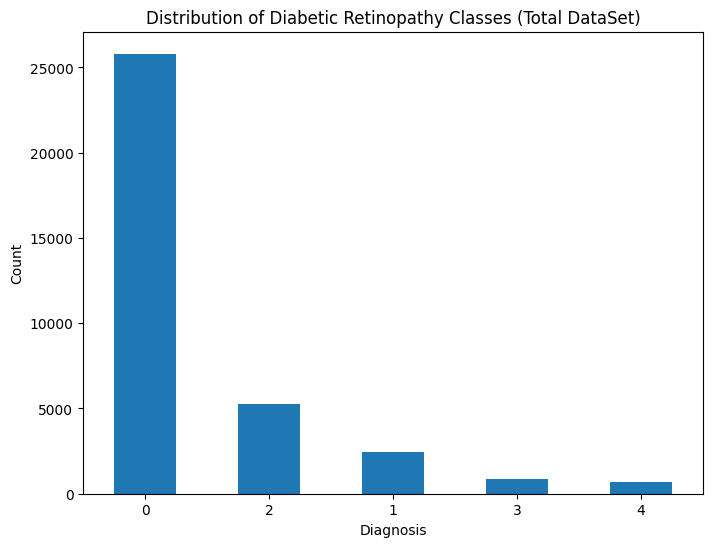

In [8]:
value_counts = df_train_csv['level'].value_counts()                    
# Plot using matplotlib
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar')
plt.title('Distribution of Diabetic Retinopathy Classes (Total DataSet)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keep the x-axis labels horizontal
plt.show()

Diagnosis
* 0(NO DR)     25802
* 2  Mild      5288
* 1  Moderate  2438
* 3  Sever     872
* 4 (PDR)      708

# Split the Data & Sub Sample data

In [9]:
#Stratified Sampling and split the data 
str_data = df_train_csv
subset_size = 0.3 # subSet of the data 
# Perform train-test split using subset size for the training data
df_train, df_test = train_test_split(str_data, test_size=1 - subset_size, stratify=str_data['level'], random_state=42)

# Print the shapes of the resulting datasets
print(f'Training Data Shape: {df_train.shape}') #Training Data Shape: (10532, 2)
print(f'Testing Data Shape: {df_test.shape}')   #Testing Data Shape: (24576, 2)


Training Data Shape: (10532, 2)
Testing Data Shape: (24576, 2)


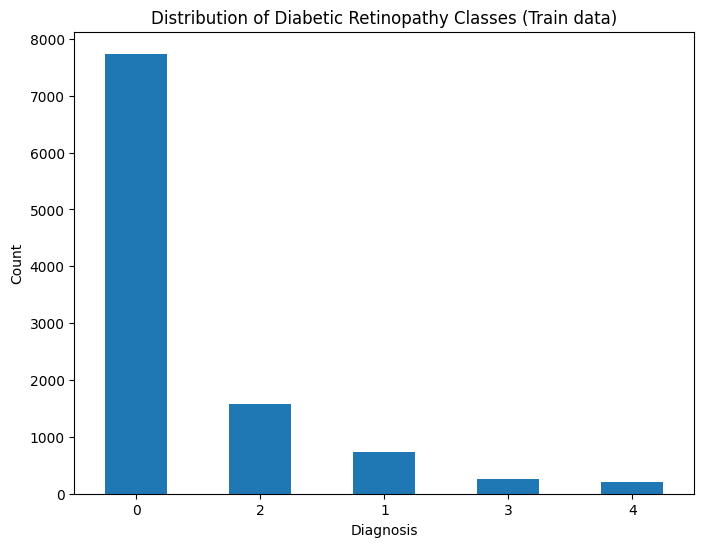

In [10]:
#Train data distribution
#df_train['level'].value_counts()
plt.figure(figsize=(8, 6))
df_train['level'].value_counts().plot(kind='bar')
plt.title('Distribution of Diabetic Retinopathy Classes (Train data)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keep the x-axis labels horizontal
plt.show()

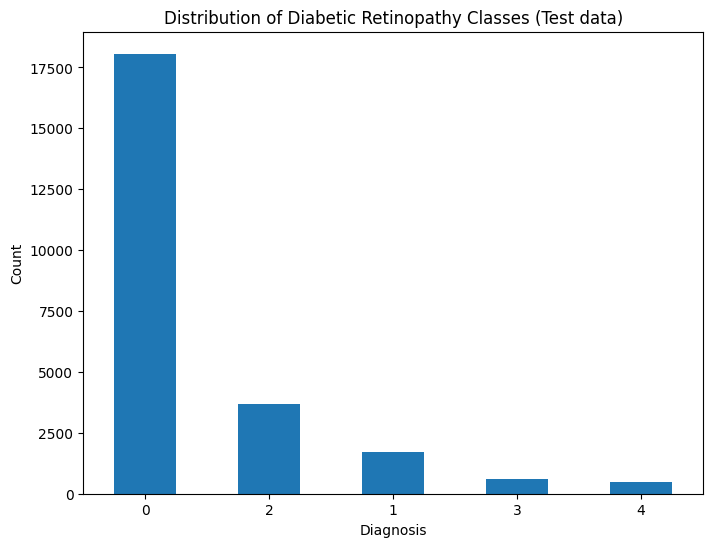

In [11]:
#Test data Distribution
plt.figure(figsize=(8, 6))
df_test['level'].value_counts().plot(kind='bar')
plt.title('Distribution of Diabetic Retinopathy Classes (Test data)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keep the x-axis labels horizontal
plt.show()

# PrePreocessing

In [12]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and 
    returns the a preprocessed image with 
    3 channels
    
    :param img: A NumPy Array that will be cropped
    :param tol: The tolerance used for masking
    
    :return: A NumPy array containing the cropped image
    """
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image, sigmaX=10):
    """
    The whole preprocessing pipeline:
    1. Read in image
    2. Apply masks
    3. Resize image to desired size
    4. Add Gaussian noise to increase Robustness
    
    :param img: A NumPy Array that will be cropped
    :param sigmaX: Value used for add GaussianBlur to the image
    
    :return: A NumPy array containing the preprocessed image
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    
    return image

In [13]:
IMAGE_SIZE = (225, 225)
BATCH_SIZE = 64
NUM_CLASSES = 5
num_classes = 5
img_height = 225
img_width = 225
IMG_WIDTH = 225
IMG_HEIGHT = 225
CHANNELS = 3

In [14]:
# Define the data generator with augmentation
train_datagen = ImageDataGenerator(   # train data with data augmetataion.
    rescale=1./255,
    rotation_range=20,
    brightness_range=[1, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.1,
    preprocessing_function=preprocess_image
)
val_datagen = ImageDataGenerator(rescale=1./255
                                ,preprocessing_function=preprocess_image)

test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory='/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped',
    x_col='image',
    y_col='level',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    subset='training')

val_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory='/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped',
    x_col='image',
    y_col='level',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    subset='validation')

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory='/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped',
    x_col='image',
    y_col='level',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw')


Found 9479 validated image filenames.
Found 1053 validated image filenames.
Found 24576 validated image filenames.


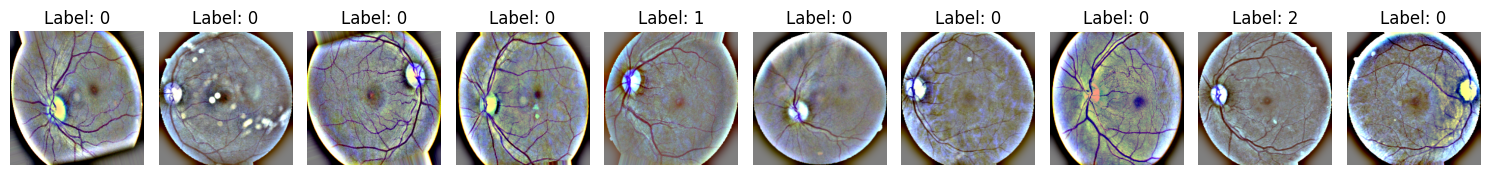

In [16]:
# Number of images to display
num_images = 10

# Retrieve a batch of images and labels
images, labels = next(train_generator)
# Plotting the images
plt.figure(figsize=(15, 10))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(images[i])  # Display the image
    plt.axis('off')  # Hide axis
    plt.title(f'Label: {labels[i]}')  # Display the label

plt.tight_layout()
plt.show()

# Model

In [17]:
efficientnet = EfficientNetB5(include_top=False, weights='imagenet', input_shape=(225,225,3))

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [18]:
# instantiating the model in the strategy scope creates the model on the TPU
#strategy = tf.distribute.TPUStrategy(tpu)
#with strategy.scope():
    #def build_model():
        #model = Sequential()
        
        # Add the efficientnet model here
        #model.add(efficientnet)  
        #model.add(layers.GlobalAveragePooling2D())
        #model.add(layers.Dense(256, activation='relu'))  
        #model.add(layers.Dense(256, activation='relu'))  
        #model.add(layers.Dense(4, activation='softmax'))  
        
        #model.compile(
            #loss='sparse_categorical_crossentropy',  
            #optimizer=Adam(),
            #metrics=['accuracy']
        #)
        
        #return model



In [19]:
#model_1 = build_model() #here Model_1 is efficient B5
#model_1.summary()

# CallBacks

In [20]:
# Define callbacks
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)'''''

In [21]:
#Train the model
#m1_history = model_1.fit(
    #train_generator,
    #steps_per_epoch=len(train_generator)// BATCH_SIZE,
    #epochs=35,
    #validation_data = val_generator,
    #validation_steps=len(val_generator)// BATCH_SIZE,
    #callbacks= [early_stopping, checkpoint, reduce_lr]
#)